# А/B-тест на данных с '2024-05-31' по '2024-06-06'. Экспериментальные группы 1 и 2

**В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля.**

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Задача — проанализировать данные А/B-теста.

Ключевая метрика - CTR (likes/views)

## Подготовительный этап

In [3]:
# Импортируем нужные библиотеки

import pandahouse
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats

In [25]:
# Настроим размер графиков Seaborn

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [26]:
# Устанавливаем параметры соединения с базой данных

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20240620'
}

In [27]:
# Берем данные из базы по временному промежутку АB-теста (с 2024-05-31 по 2024-06-06)

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) BETWEEN '2024-05-31' AND '2024-06-06'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [28]:
# Проверим корректность подгрузки данных

print(df.head(10))

   exp_group  user_id  likes  views       ctr
0          1   109963      3     15  0.200000
1          1    26117     32    141  0.226950
2          1   138232     18     73  0.246575
3          1    26295     39    141  0.276596
4          1    18392      7     32  0.218750
5          2   131473      9    108  0.083333
6          2    23985      7     87  0.080460
7          2    24523     11    101  0.108911
8          2    32420     13     44  0.295455
9          2    24239     40     90  0.444444


In [128]:
# exp_group = 1 - Все по-старому
# exp_group = 2 - Рекомендации "похожих на лайкнутые постов"

In [155]:
# Посмотрим описательные статистики для контрольной группы

df[df.exp_group == 1].describe()

,exp_group,user_id,likes,views,ctr
count,10020.0,10020.000000,10020.000000,10020.000000,10020.000000
mean,1.0,75766.859381,14.005888,66.820659,0.216774
std,0.0,53174.508357,9.853010,45.281800,0.082969
min,1.0,206.000000,0.000000,1.000000,0.000000
25%,1.0,22170.000000,7.000000,33.000000,0.163636
50%,1.0,109387.000000,12.000000,57.000000,0.205882
75%,1.0,126164.500000,19.000000,90.000000,0.257870
max,1.0,140740.000000,68.000000,326.000000,0.722222


In [156]:
# Посмотрим описательные статистики для тестовой группы

df[df.exp_group == 2].describe()

,exp_group,user_id,likes,views,ctr
count,9877.0,9877.000000,9877.000000,9877.000000,9877.000000
mean,2.0,75255.752455,13.370052,66.766630,0.216102
std,0.0,53337.842945,11.822436,45.451031,0.142870
min,2.0,220.000000,0.000000,1.000000,0.000000
25%,2.0,21719.000000,5.000000,32.000000,0.096774
50%,2.0,109219.000000,10.000000,57.000000,0.153285
75%,2.0,126105.000000,18.000000,91.000000,0.323529
max,2.0,140059.000000,93.000000,341.000000,0.900000


<Axes: xlabel='ctr', ylabel='Count'>

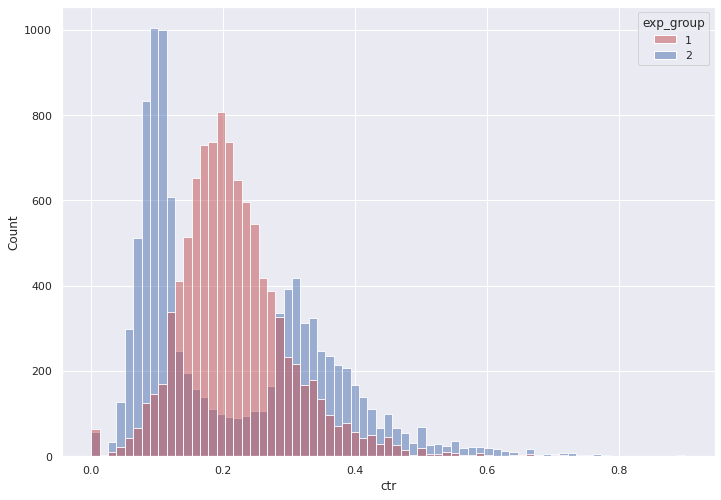

In [119]:
# Визуализируем подгруженные данные

sns.histplot(data=df, x='ctr', hue='exp_group', palette=['r', 'b'], alpha=0.5, kde=False)

In [163]:
# Попробуем взять из датасета также данные по срезам пользователей и рассмотреть есть ли какая-либо взаимосвязь между
# доступными срезами и существующими модами в тестовой группе

q_viz = """
SELECT exp_group, 
    user_id,
    os,
    source,
    gender,
    country,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) BETWEEN '2024-05-31' AND '2024-06-06'
    and exp_group in (1,2)
GROUP BY exp_group, user_id, os, source, gender, country
"""

df_viz = pandahouse.read_clickhouse(q_viz, connection=connection)

<Axes: xlabel='ctr', ylabel='Count'>

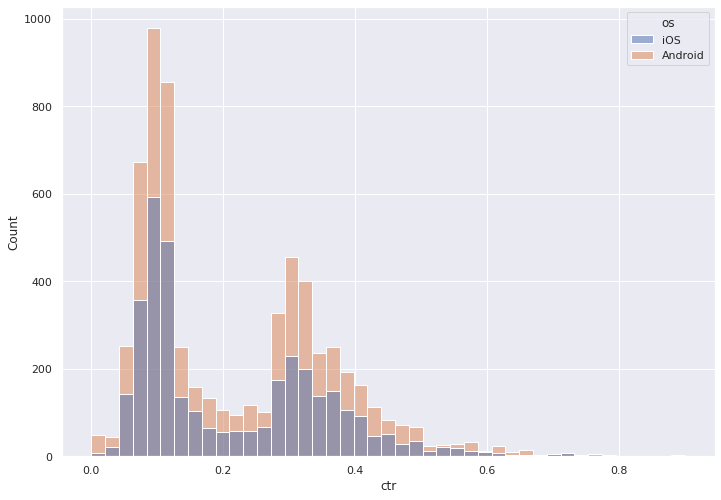

In [164]:
# Срез по операционной системе

sns.histplot(df_viz[df_viz.exp_group==2], x='ctr', hue='os', alpha=0.5)

<Axes: xlabel='ctr', ylabel='Count'>

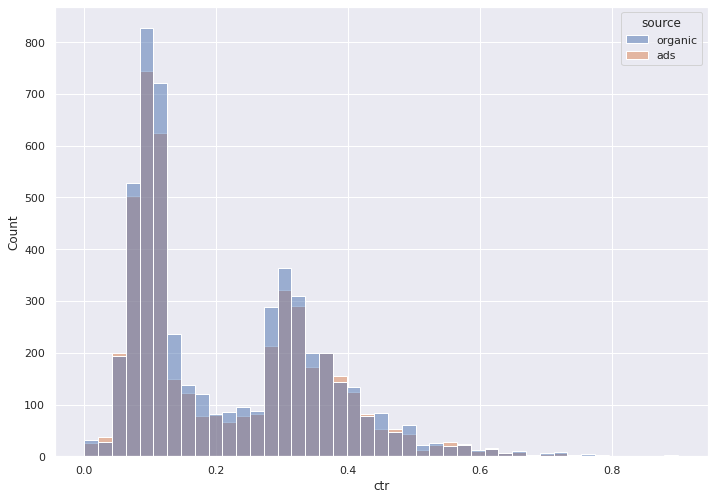

In [160]:
# Срез по каналу привлечения

sns.histplot(df_viz[df_viz.exp_group==2], x='ctr', hue='source', alpha=0.5)

<Axes: xlabel='ctr', ylabel='Count'>

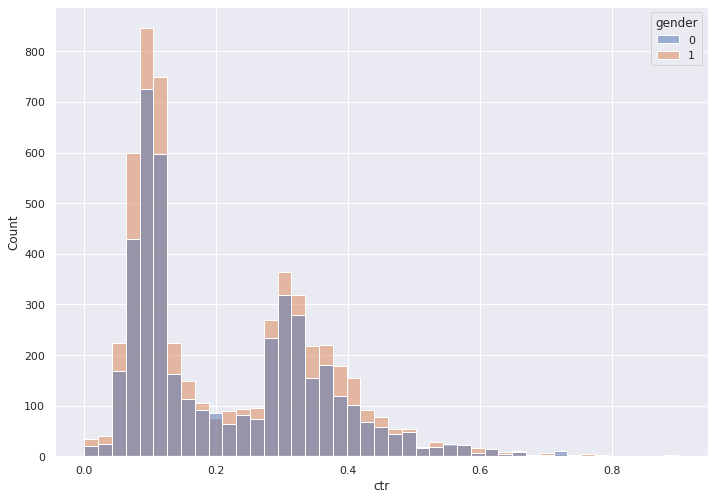

In [161]:
# Срез по полу

sns.histplot(df_viz[df_viz.exp_group==2], x='ctr', hue='gender', alpha=0.5)

<Axes: xlabel='ctr', ylabel='Count'>

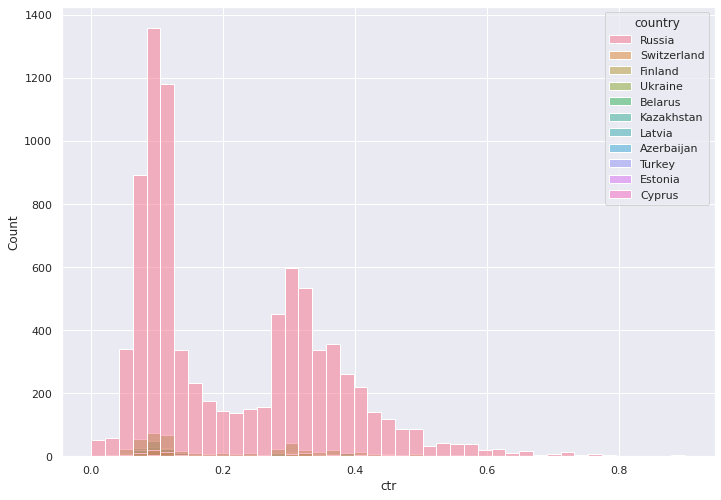

In [162]:
# Срез по странам

sns.histplot(df_viz[df_viz.exp_group==2], x='ctr', hue='country', alpha=0.5)

**Промежуточный вывод по этапу подготовки и визуализации исходных данных:**

Подсчет среднего CTR по исследуемым экспериментальным группам показал уменьшение метрики в тестовой группе по сравнению с контрольной. Также можем наблюдать падение среднего кол-ва просмотров и лайков. В результате визуализации распределений CTR также видим, что распределение тестовой группы бимодальное, при этом большее количество наблюдений находится слева от CTR контрольной группы (т.е. меньше контрольной группы).

Визуализация распределения по имеющимся срезам не показала связь между конкретным подтипом пользователя и одной из двух мод. Обе моды проявляются на всех пользователях вне зависимости от среза.

## Анализ экспериментальных групп

Для проведения анализа A/B-теста воспользуемся следующими тестами:
1. t-тест Стьюдента
2. t-тест со сглаживанием по CTR
3. Тест Манна-Уитни
4. Пуассоновский бутстрап
5. Бакетное преобразование (с t-тестом и тестом Манна-Уитни поверх него)

### 1. t-тест Стьюдента

- Нулевая гипотеза - Средние CTR контрольной и тестовой группы не различаются.
- Альтернативная гипотеза - Средние CTR контрольной и тестовой группы имеют статистически значимое различие.

In [53]:
# Запускаем t-тест

print(stats.ttest_ind(df[df.exp_group == 1].ctr.values, df[df.exp_group == 2].ctr.values, equal_var=False))

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)


**Промежуточный вывод по t-тесту:**

T-тест не показал статистических значимых различий между экспериментальными группами. Принимается нулевая гипотеза. Однако стоит не забывать и о специфике распределения тестовой группы.

### 2. t-тест Стьюдента со сглаживанием по CTR

Нулевая и альтернативная гипотезы - аналогичны обычному t-тест. Различие заключается в применении в данном методе сглаживания Лапласса для избавления от зашумлений в CTR. Недостаток метода - отсутствие теоретических гарантий в том, что его направленность совпадает с направленностью общего количества кликов.

In [55]:
# Создаем функцию для расчета сглаженного CTR

def get_smoothed_ctr(user_likes, user_views, global_ctr, alpha):
    smoothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smoothed_ctr

In [56]:
# Рассчитываем общий CTR для контрольной и тестовой групп

global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

In [57]:
# Создаем новый датасет для данных только контрольной группы

group1 = df[df.exp_group == 1].copy()

In [58]:
# Добавляем в датасет контрольной группы колонку сглаженного CTR, рассчитываемую  по созданной ранее функции

group1['smoothed_ctr'] = df.apply(
    lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

In [70]:
# Убедимся в корректности осуществленных действий

group1.head()

,exp_group,user_id,likes,views,ctr,smoothed_ctr
0,1,109963,3,15,0.200000,0.202401
1,1,26117,32,141,0.226950,0.226356
2,1,138232,18,73,0.246575,0.244205
3,1,26295,39,141,0.276596,0.274302
4,1,18392,7,32,0.218750,0.217514


<Axes: xlabel='ctr', ylabel='Count'>

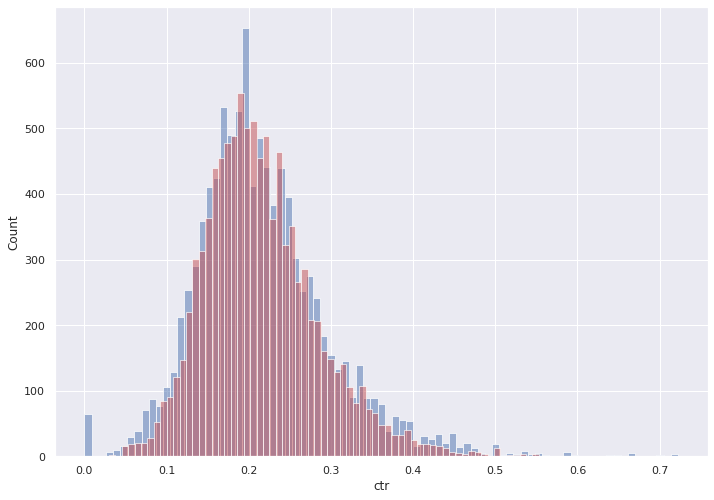

In [59]:
# Построим гистограммы для неизмененного и сглаженного CTR контрольной группы
# Видим, что распределение сгладилось, зашумление стало меньше

sns.histplot(group1.ctr, 
             kde = False, color='b', alpha=0.5)
sns.histplot(group1.smoothed_ctr, 
             kde = False, color='r', alpha=0.5)

In [62]:
# Создаем новый датасет только для тестовой группы

group2 = df[df.exp_group == 2].copy()

In [63]:
# Добавляем в датасет тестовой группы колонку сглаженного CTR, рассчитываемую  по созданной ранее функции

group2['smoothed_ctr'] = df.apply(
    lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

In [69]:
# Убедимся в корректности осуществленных действий

group2.head()

,exp_group,user_id,likes,views,ctr,smoothed_ctr
5,2,131473,9,108,0.083333,0.088507
6,2,23985,7,87,0.080460,0.086970
7,2,24523,11,101,0.108911,0.113219
8,2,32420,13,44,0.295455,0.285740
9,2,24239,40,90,0.444444,0.431592


<Axes: xlabel='ctr', ylabel='Count'>

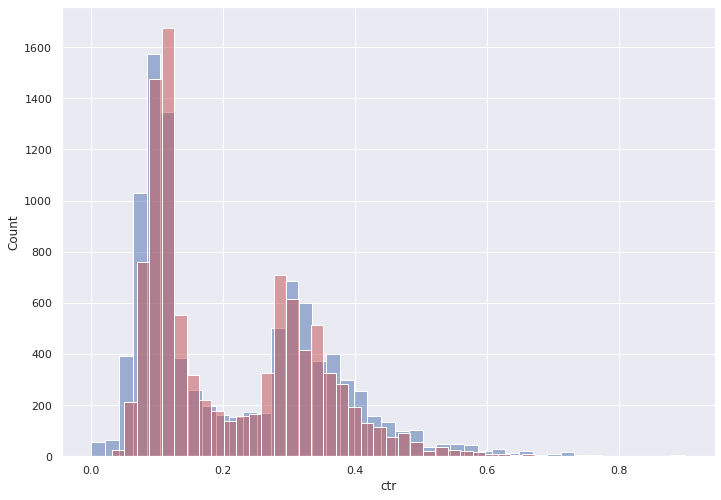

In [64]:
# Построим гистограммы для неизмененного и сглаженного CTR контрольной группы
# Момент сглаживания сомнителен

sns.histplot(group2.ctr, 
             kde = False, color='b', alpha=0.5)
sns.histplot(group2.smoothed_ctr, 
             kde = False, color='r', alpha=0.5)

In [66]:
# Применим t-тест поверх сглаженного CTR

print(stats.ttest_ind(group1['smoothed_ctr'].values, group2['smoothed_ctr'].values, equal_var=False))

Ttest_indResult(statistic=1.9460491517027683, pvalue=0.05166679015318526)


**Промежуточный вывод по t-тесту поверх сглаженного CTR:**

T-тест поверх сглаженного CTR не показал статистических значимых различий между экспериментальными группами, однако в отличие от "ванильного" t-теста уже оказался гораздо ближе к статистически значимым различиям между двумя группами. Принимается нулевая гипотеза.

### 3. Тест Манна-Уитни

Нулевая гипотеза - Тестовая и контрольная группа не имеют различий.

Альтернативная гипотеза - Тестовая и контрольная группа имеют статистически значимые различия. (Cуммы рангов двух групп отличаются в какую-то сторону.)

In [80]:
# Применяем тест Манна-Уитни к исходным данным CTR пользователей

print(stats.mannwhitneyu(df[df.exp_group==1].ctr.values, df[df.exp_group==2].ctr.values, alternative='two-sided'))

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)


**Промежуточный вывод по тесту Манна-Уитни:**

Тест Манна-Уитни показал статистически значимое различие между экспериментальными группами. При этом, направление данных различий неизвестно. Нулевая гипотеза отклоняется, принимаем альтернативную гипотезу.

### 4. Пуассоновский бутстрап

Смысл метода:
- Устанавливаем, что имеющиеся выборки являются хорошей моделью генеральной совокупности.
- Выбираем из них многократные подвыборки с повторением и считаем по каждой из них общий CTR.
- Визуализируем распределения общих CTR для подвыборок из тестовой и контрольной групп для определения наличия и направления эффекта.

In [81]:
# Создаем функцию для генерации попаданий наблюдения в подвыборку с помощью распределения Пуассона и рассчитываем общий CTR 

def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [85]:
# Создаем массивы, хранящие кол-во лайков и просмотров по каждой из экспериментальных групп

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

In [86]:
# Применяем функцию бутстрапа к массивам

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<Axes: ylabel='Count'>

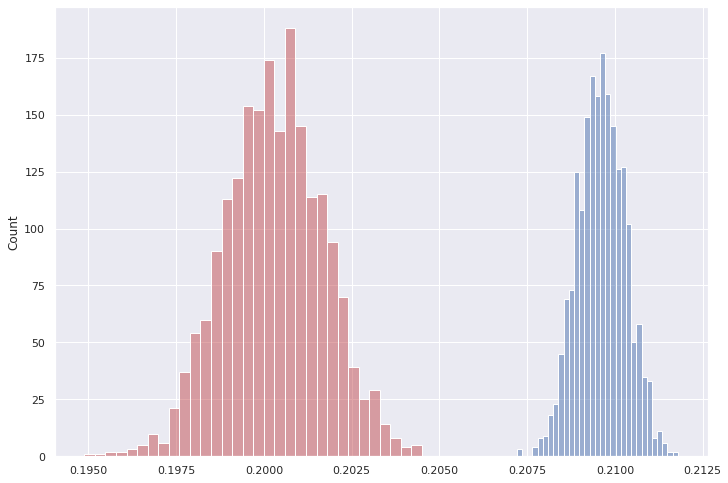

In [88]:
# Визуализируем полученные распределения
# Распределение контрольной группы соответствует синему цвету
# Распредеение тестовой группы соответствует красному цвету

sns.histplot(ctr1, color='b', alpha=0.5)
sns.histplot(ctr2, color='r', alpha=0.5)

<Axes: ylabel='Count'>

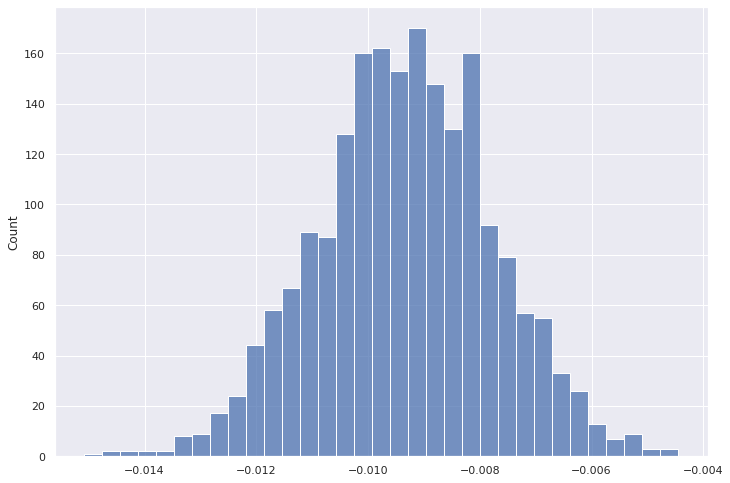

In [90]:
# Визуализируем разницу между глобальными CTR

sns.histplot(ctr2 - ctr1)

**Промежуточный вывод пуассоновскому бутстрапу:**

В результате применения пуассоновского бутстрапа мы обнаружили различие в общих CTR подвыборок тестовой и контрольной групп. Распределения CTR не имеют пересечений, все значения CTR контрольной группы оказались ниже значений CTR тестовой группы. Распределение разницы CTR между контрольной и тестовой группами находится полностью левее от нуля. Экспериментальные группы различны, CTR тестовой группы меньше CTR контрольной.

### 5. Бакетное преобразование

Смысл метода:
- Устанавливаем, что имеющиеся выборки являются хорошей моделью генеральной совокупности.
- Выбираем из них многократные подвыборки с повторением и считаем по каждой из них общий CTR.
- Визуализируем распределения общих CTR для подвыборок из тестовой и контрольной групп для определения наличия и направления эффекта.

In [94]:
# Подгрузим данные из кликхауса с разбиением на бакеты и рассчитанными под них CTR

q_bucket = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2024-05-31' and '2024-06-06'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_bucket = pandahouse.read_clickhouse(q2, connection=connection)

In [96]:
# Убедимся в корректности подгруженных данных

df_bucket.head()

,exp_group,bucket,bucket_ctr
0,1,0,0.200592
1,2,0,0.196510
2,1,1,0.208799
3,2,1,0.210375
4,1,2,0.204632


<Axes: xlabel='bucket_ctr', ylabel='Count'>

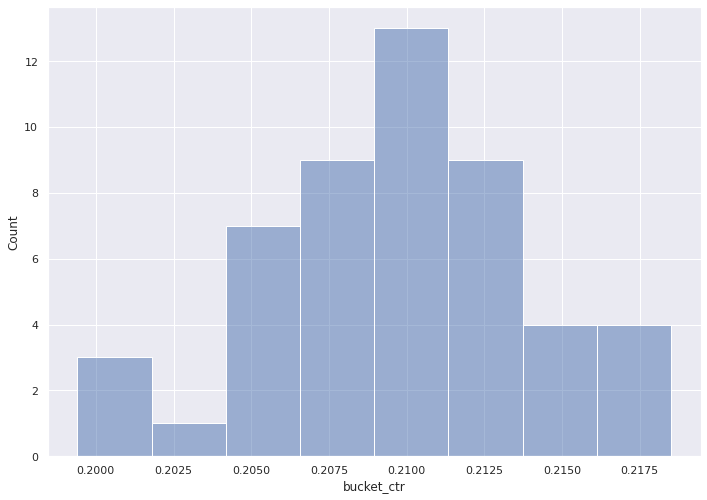

In [101]:
# Визуализируем распределения бакетов

sns.histplot(df_bucket[df_bucket.exp_group==1].bucket_ctr, alpha=0.5)

<Axes: xlabel='bucket_ctr', ylabel='Count'>

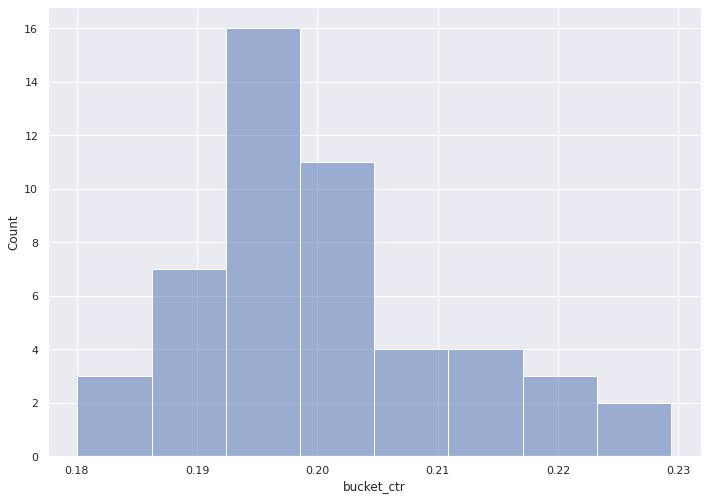

In [102]:
sns.histplot(df_bucket[df_bucket.exp_group==2].bucket_ctr, alpha=0.5)

In [124]:
# Поcмотрим среднее по бакетам

df_bucket[df_bucket.exp_group == 1].bucket_ctr.mean()

0.20969361570538578

In [125]:
df_bucket[df_bucket.exp_group == 2].bucket_ctr.mean()

0.2004567038618196

In [126]:
# Применим тест Манна-Уитни поверх бакетного преобразования

print(stats.mannwhitneyu(df_bucket[df_bucket.exp_group == 1].bucket_ctr.values,
                         df_bucket[df_bucket.exp_group == 2].bucket_ctr.values, alternative='two-sided'))

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)


In [127]:
# Применим t-тест Стьюдента поверх бакетного преобразования

print(stats.ttest_ind(df_bucket[df_bucket.exp_group == 1].bucket_ctr.values,
                         df_bucket[df_bucket.exp_group == 2].bucket_ctr.values, equal_var=False))

Ttest_indResult(statistic=5.614819358149381, pvalue=4.592644937473873e-07)


**Промежуточный вывод по результатам тестов поверх бакетного преобразования:**

В результате осуществления анализа поверх бакетного преобразования оба теста заметили наличие статистически значимого различия между экспериментальными группами. Средний CTR по бакетам при этом больше у контрольной группы.

## Вывод по результатам проведения A/B-теста:

В процессе проведения анализа А/B-теста было обнаружено уменьшение среднего CTR в тестовой группе по сравнению с контрольной. Данные экспериментальных групп были далее проверены различными статистическими тестами на наличие статистической значимости в различиях между двумя группами.

Результаты тестов представлены в таблице:

| Тест               | Нулевая гипотеза |
| ------------------ | -----------------|
| t-тест на "сырых" данных | Подтверждена |
| t-тест по сглаженным CTR | Подтверждена |
| Тест Манна-Уитни | Отвергнута |
| Пуассоновский бутстрап | Отвергнута |
| t-тест поверх бакетного преобразования | Отвергнута |
| Тест Манна-Уитни поверх бакетного преобразования | Отвергнута |

Поведение t-теста в данном случае может быть обосновано спецификой распределения CTR в тестовой группе. Распределение имеет скошенный характер и бимодально. Полученное значение p_value t-теста поверх данных со сглаженным CTR при этом максимально приблизилось к установленному уровню значимости в 0.05.

Важно также отметить, что результат анализа методом пуассоновского бутстрапа сходится с изначальным предположением о том, что ключевая метрика упала в тестовой группе по сравнению с контрольной.

Таким образом, на основании проведенных тестов рекомендуется не вводить обновленный алгоритм показа постов похожих на ранее лайкнутые, т.к. результаты анализа показали либо отсутствие эффекта, либо его наличие в отрицательную сторону.